In [5]:
%matplotlib inline
import jplus
import os
import pickle
import elgtools as elg
import numpy as np
import matplotlib.pyplot as plt
import Read_Mocks as read
import MockJPLUS as mtools
import matplotlib.gridspec as gsc

Mockpath = '/home/CEFCA/aaorsi/work/JPLUS_Mock/new/Lines/'
namelc   = 'LightCone_SA_0_'

plt.rcParams['figure.figsize'] = 25, 25



In [2]:
# Loading Lightcone galaxies
nCone = 512
lcone = []
print 'reading Lightcone...'
for i in range(nCone): #nCone):
    nameIn = '%s%s%d' % (Mockpath, namelc, i)
    ilc = read.readmock_chunk_PythonCut(nameIn, zspace = True)
    lcone.append(ilc[0])
    
dcone = np.concatenate(lcone)



reading Lightcone...


In [3]:


# inferring the redshift by looking at different dMs in the mock:

r_mock     = mtools.app_mag(dcone, 'rSDSS')
g_mock     = mtools.app_mag(dcone, 'gSDSS')
i_mock     = mtools.app_mag(dcone, 'iSDSS')
z_mock     = mtools.app_mag(dcone, 'zSDSS')
u_mock     = mtools.app_mag(dcone, 'uJAVA')
j0660_mock = mtools.app_mag(dcone, 'J0660')
j0861_mock = mtools.app_mag(dcone, 'J0861')
j0515_mock = mtools.app_mag(dcone, 'J0515')
j0378_mock = mtools.app_mag(dcone, 'J0378')

print 'Computing 3FM over several narrow bands ...'

mock_dm_J0660 = mtools.gen_3fm(j0660_mock, r_mock, 
                          i_mock,Broad_NoLineName='iSDSS', LineFilterName='J0660', Broad_LineName='rSDSS')

mock_dm_J0515 = mtools.gen_3fm(j0515_mock, g_mock, 
                          r_mock,Broad_NoLineName='rSDSS', LineFilterName='J0515', Broad_LineName='gSDSS')

mock_dm_J0378 = mtools.gen_3fm(j0378_mock, u_mock, 
                          g_mock,Broad_NoLineName='gSDSS', LineFilterName='J0378', Broad_LineName='uJAVA')

mock_dm_J0861 = mtools.gen_3fm(j0861_mock, z_mock, 
                          i_mock,Broad_NoLineName='iSDSS', LineFilterName='J0861', Broad_LineName='zSDSS')


print dcone.dtype

f_j0660 = jplus.datasets.fetch_jplus_filter('J0660') # Filter transmission curve

w_oii = 3727.0 # OII rest-frame
z_oii = elg.zline(w_oii, f_j0660.wave, f_j0660.throughput)

w_ha = 6563.0
z_ha = elg.zline(w_ha, f_j0660.wave, f_j0660.throughput)

w_hb = 4861.0
z_hb = elg.zline(w_hb, f_j0660.wave, f_j0660.throughput)

w_oiii = 5007.0
z_oiii = elg.zline(w_oiii, f_j0660.wave, f_j0660.throughput)


Computing 3FM over several narrow bands ...


j-plus [INFO]: Fetching  J-PLUS filters


[('Type', '<i4'), ('Mvir', '<f4'), ('pos', '<f4', (3,)), ('vel', '<f4', (3,)), ('sfr', '<f4'), ('sfr_inst', '<f4'), ('BulgeMass', '<f4'), ('DiskMass', '<f4'), ('Time', '<f4'), ('redshift', '<f4'), ('BlackholeMass', '<f4'), ('MetalColdGas', '<f4'), ('ColdGas', '<f4'), ('MassWeightAge', '<f4'), ('ObsMagDust', '<f4', (12,))]


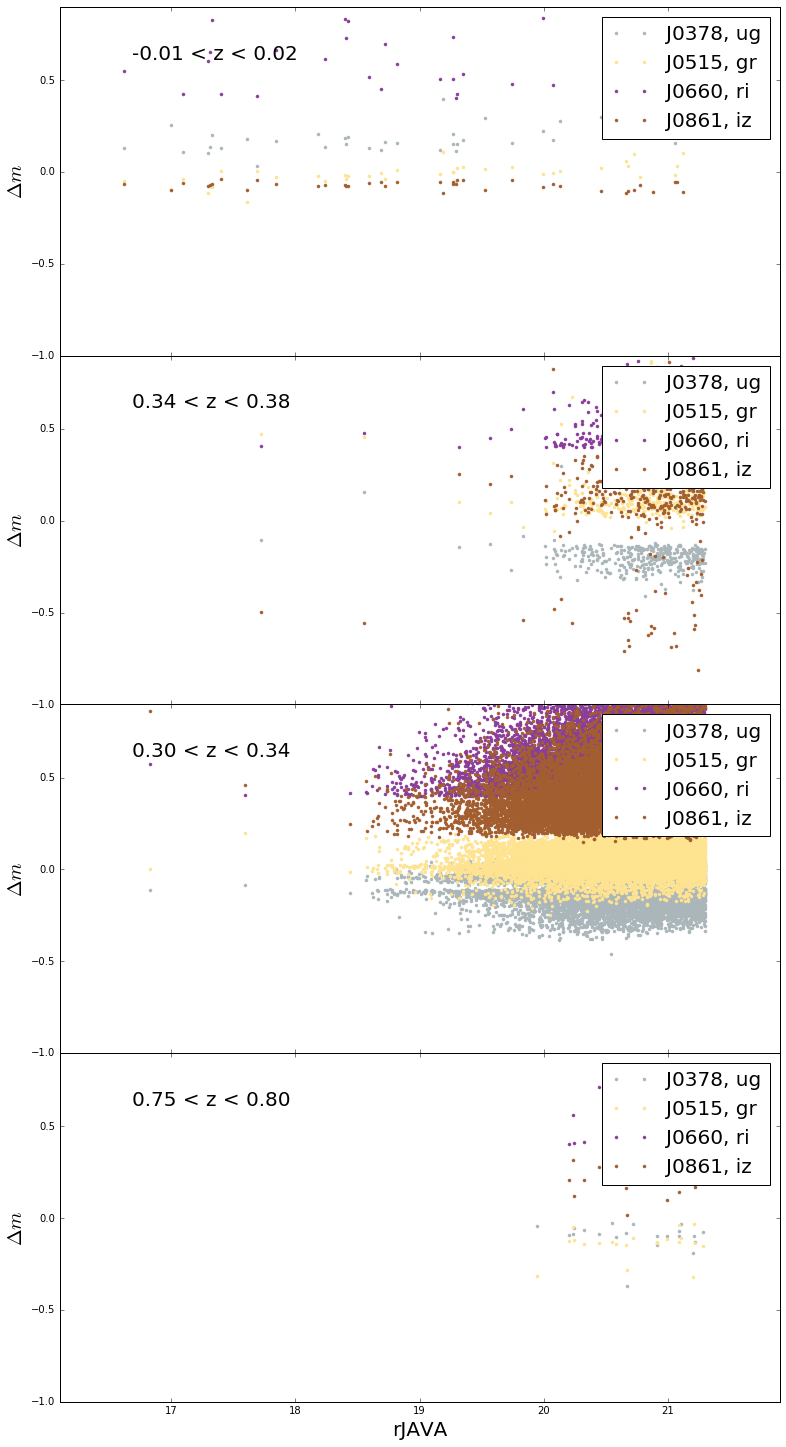

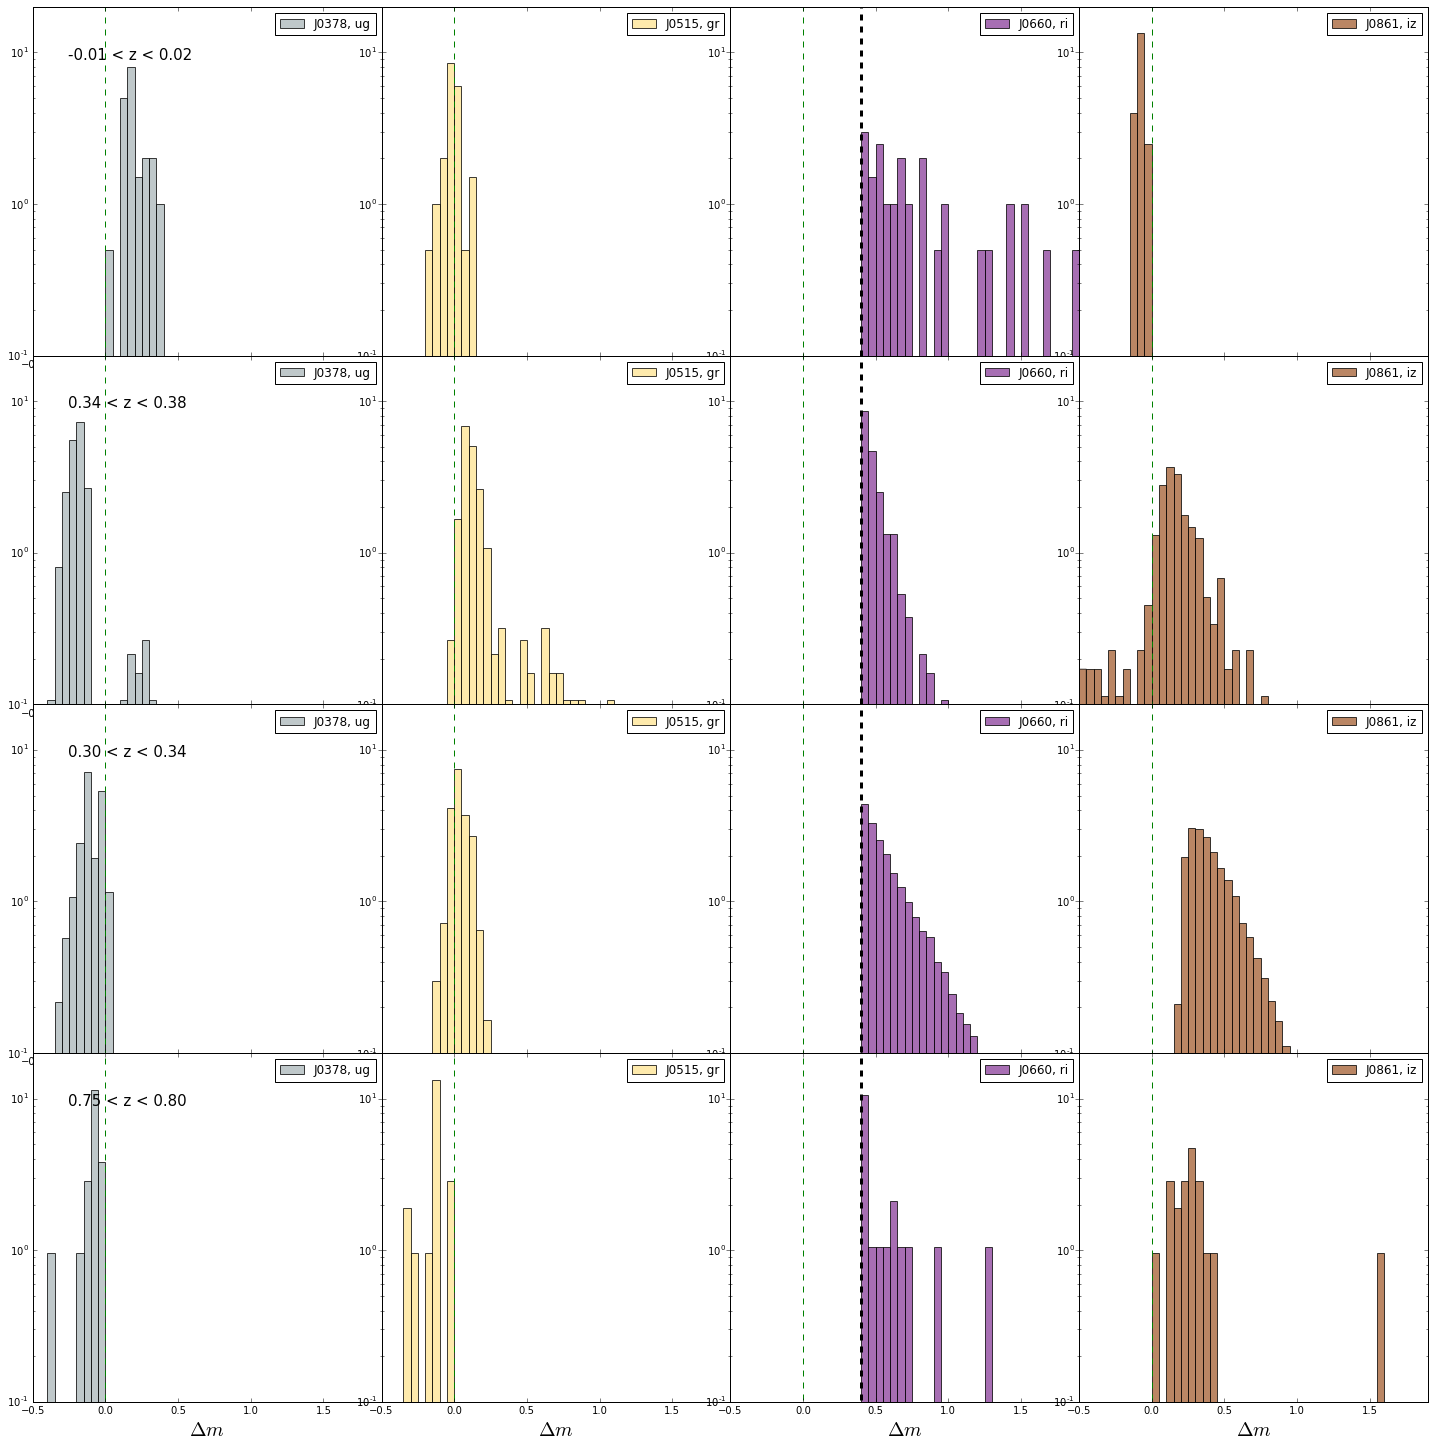

In [6]:
cnames = ['J0378, ug', 'J0515, gr', 'J0660, ri', 'J0861, iz']
cmap = plt.cm.Accent(np.linspace(.1,.9,4))

def plot_dm_z(ax, zr, 
              x = r_mock, xname='rJAVA', make_xlabel=True, dm_j0660_min = -10, mag_range = [16,25]):

    sel = (dcone['redshift'] > zr[0]) & (dcone['redshift'] < zr[1]) & (x > mag_range[0]) & (
    x < mag_range[1]) & (mock_dm_J0660 >= dm_j0660_min) 

    ax.plot(x[sel],mock_dm_J0378[sel],'.', color=cmap[0], label=cnames[0])
    ax.plot(x[sel],mock_dm_J0515[sel],'.', color=cmap[1], label=cnames[1])
    ax.plot(x[sel],mock_dm_J0660[sel],'.', color=cmap[2], label=cnames[2])
    ax.plot(x[sel],mock_dm_J0861[sel],'.', color=cmap[3], label=cnames[3])
    
    ax.set_ylim([-1,0.9])
    ax.set_xlim([16.1,21.9])
    if make_xlabel:
        ax.set_xlabel(xname,fontsize=20)
    
    ax.set_ylabel(r'$\Delta m$', fontsize=20)
    ax.legend(fontsize=20)
    zstr = '%.2f < z < %.2f' % (zr[0], zr[1])
    ax.text(0.1,0.85,zstr, fontsize=20,
           transform=ax.transAxes)
    
    return [mock_dm_J0378[sel], mock_dm_J0515[sel], mock_dm_J0660[sel], mock_dm_J0861[sel]], zstr


dm_min = 0.4

plt.figure('dm')

gs = gsc.GridSpec(4,1)
gs.update(wspace=0.0, hspace=0.0, left=0.5)

ax = plt.subplot(gs[0,0])
m_ha, zha = plot_dm_z(ax, z_ha, make_xlabel=False, dm_j0660_min = dm_min )

ax = plt.subplot(gs[1,0])
m_hb, zhb = plot_dm_z(ax, z_hb, make_xlabel=False, dm_j0660_min = dm_min )

ax = plt.subplot(gs[2,0])
m_oiii, zoiii = plot_dm_z(ax, z_oiii, make_xlabel=False, dm_j0660_min = dm_min )

ax = plt.subplot(gs[3,0])
m_oii, zoii = plot_dm_z(ax, z_oii, dm_j0660_min = dm_min )

plt.show()



plt.figure('dm_hist')

gs2 = gsc.GridSpec(4,4)
gs2.update(wspace=0.0, hspace=0.0)


m_arr = [m_ha, m_hb, m_oiii, m_oii]
z_arr = [zha, zhb, zoiii, zoii]



for j in range(len(m_arr)):
    mj = m_arr[j]
    for i in range(len(m_ha)):
        ax2 = plt.subplot(gs2[j,i])    
        ax2.hist(mj[i],bins= 50, label=cnames[i], facecolor=cmap[i],normed=True,range=[-.5,2],alpha=0.75, log=True)
        ax2.set_ylim([1e-1,20])
        ax2.set_xlim([-.5, 1.9])
        if i == 0:
            ax2.text(0.1,0.85, z_arr[j],fontsize=15, transform=ax2.transAxes)
        ax2.legend()
        
        ax2.plot([0,0], [1e-3,100],'--')
        if i == 2:
            ax2.plot([dm_min, dm_min], [-1,100],'--',linewidth=3,color='black')
        ax2.set_xlabel(r'$\Delta m$',fontsize=20)
    
    
    
plt.show()




